# DATA606 Week 8 & 9 - Modeling
Team 2 UMBC Spring 2024

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### File imports

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn import set_config

#visuals
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams


#model selection tools
from sklearn.ensemble import VotingRegressor
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.model_selection import KFold


#models
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge


import warnings
warnings.filterwarnings(action='ignore')

## Data Transformation

### Senator Approval Ratings and Demographic Data

In [3]:
df = pd.read_csv('/content/drive/MyDrive/UMBC Fall 2023/DATA606 - Capstone/senator data/merged.csv',parse_dates=['birthday','start_date','end_date'])

In [4]:
df = df.rename(columns={'Emotion (Majority)': 'emotion_majority', 'Race (Majority)': 'race_majority', 'Valence (Mean)': 'valence_mean'})

In [5]:
df.dtypes

full_name                   object
pct                        float64
birthday            datetime64[ns]
gender                      object
party                       object
senate_class               float64
stage                       object
cycle                        int64
start_date          datetime64[ns]
end_date            datetime64[ns]
age                          int64
emotion_majority            object
race_majority               object
valence_mean               float64
dtype: object

In [6]:
df

,full_name,pct,birthday,gender,party,senate_class,stage,cycle,start_date,end_date,age,emotion_majority,race_majority,valence_mean
0,amy klobuchar,54.0,1960-05-25,F,Democrat,1.0,general,2018,2018-10-15,2018-10-30,64,happy,white,26.80534
1,amy klobuchar,55.0,1960-05-25,F,Democrat,1.0,general,2018,2018-11-02,2018-11-04,64,happy,white,26.80534
2,amy klobuchar,53.0,1960-05-25,F,Democrat,1.0,general,2018,2018-11-01,2018-11-03,64,happy,white,26.80534
3,amy klobuchar,57.0,1960-05-25,F,Democrat,1.0,general,2018,2018-10-29,2018-10-31,64,happy,white,26.80534
4,amy klobuchar,56.0,1960-05-25,F,Democrat,1.0,general,2018,2018-10-15,2018-10-17,64,happy,white,26.80534
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3030,tommy tuberville,50.0,1954-09-18,M,Republican,2.0,general,2020,2020-06-29,2020-07-02,70,neutral,white,-49.08704
3031,tommy tuberville,47.0,1954-09-18,M,Republican,2.0,general,2020,2020-06-18,2020-06-22,70,neutral,white,-49.08704
3032,tommy tuberville,49.7,1954-09-18,M,Republican,2.0,general,2020,2020-06-13,2020-06-16,70,neutral,white,-49.08704
3033,tommy tuberville,55.0,1954-09-18,M,Republican,2.0,general,2020,2020-10-11,2020-10-14,70,neutral,white,-49.08704


In [7]:
df.describe()

,pct,senate_class,cycle,age,valence_mean
count,3035.00000,3035.000000,3035.000000,3035.000000,3035.000000
mean,45.92370,2.020099,2019.887974,63.229325,26.044160
std,7.53723,0.858816,1.707897,10.562811,38.443499
min,6.20000,1.000000,2018.000000,37.000000,-73.293255
25%,43.50000,1.000000,2018.000000,55.000000,5.415104
50%,47.00000,2.000000,2020.000000,64.000000,27.554999
75%,50.00000,3.000000,2022.000000,72.000000,56.318169
max,75.00000,3.000000,2024.000000,91.000000,99.428934


In [8]:
df.shape

(3035, 14)

In [9]:
# Could we use Initial term age instead?
def calculate_servingAge(dtob,startdate):
  # Calculate the age by subtracting the birth year from the current year
  # Adjust the age if the birth month and day are after today's month and day
  return startdate.year - dtob.year - ((startdate.month, startdate.day) < (dtob.month, dtob.day))


In [10]:
# create serving_age column from birthday to start of cycle
df['serving_age'] = df.apply(lambda row : (calculate_servingAge(row.birthday, row.start_date)), axis=1 )

In [11]:
df.head()

,full_name,pct,birthday,gender,party,senate_class,stage,cycle,start_date,end_date,age,emotion_majority,race_majority,valence_mean,serving_age
0,amy klobuchar,54.0,1960-05-25,F,Democrat,1.0,general,2018,2018-10-15,2018-10-30,64,happy,white,26.80534,58
1,amy klobuchar,55.0,1960-05-25,F,Democrat,1.0,general,2018,2018-11-02,2018-11-04,64,happy,white,26.80534,58
2,amy klobuchar,53.0,1960-05-25,F,Democrat,1.0,general,2018,2018-11-01,2018-11-03,64,happy,white,26.80534,58
3,amy klobuchar,57.0,1960-05-25,F,Democrat,1.0,general,2018,2018-10-29,2018-10-31,64,happy,white,26.80534,58
4,amy klobuchar,56.0,1960-05-25,F,Democrat,1.0,general,2018,2018-10-15,2018-10-17,64,happy,white,26.80534,58


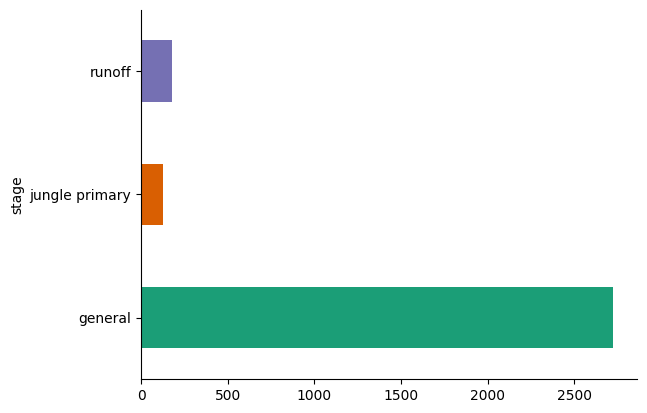

In [12]:
# @title stage

df.groupby('stage').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

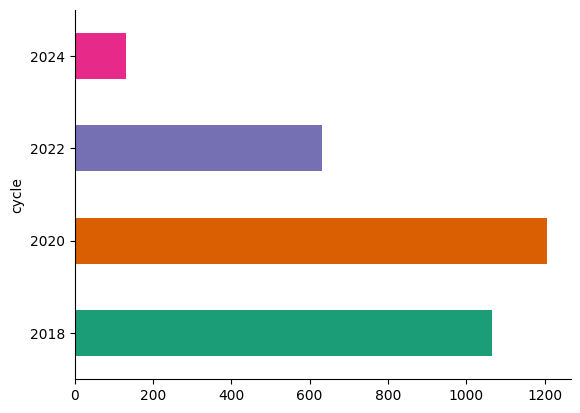

In [13]:
# @title cycle

df.groupby('cycle').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

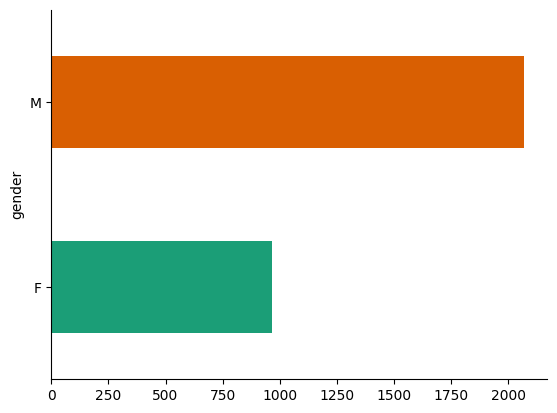

In [14]:
# @title gender

df.groupby('gender').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

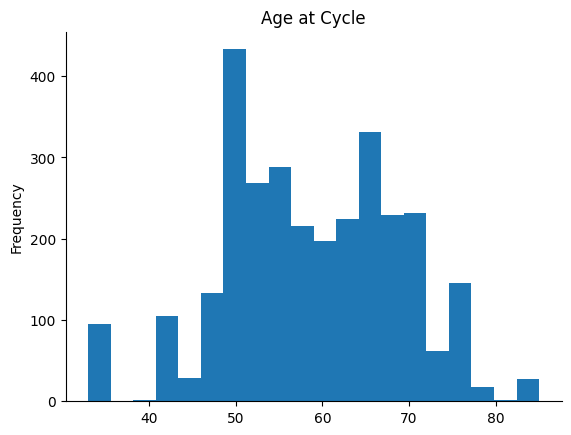

In [15]:
df['serving_age'].plot(kind='hist', bins=20, title='Age at Cycle')
plt.gca().spines[['top', 'right',]].set_visible(False)

<Axes: >

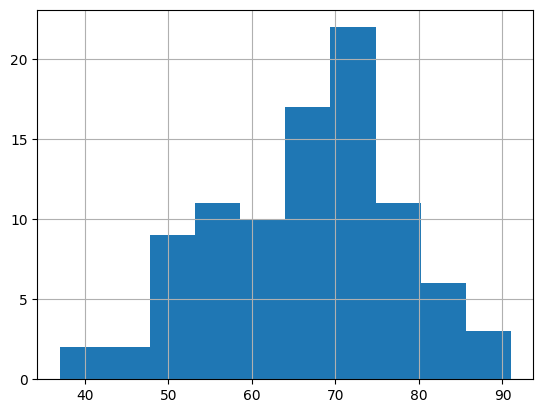

In [16]:
df.groupby('full_name')['age'].max().hist()

### TODO:
1) add the age at the time of serving -- done ✅

2) grab more features

<Axes: >

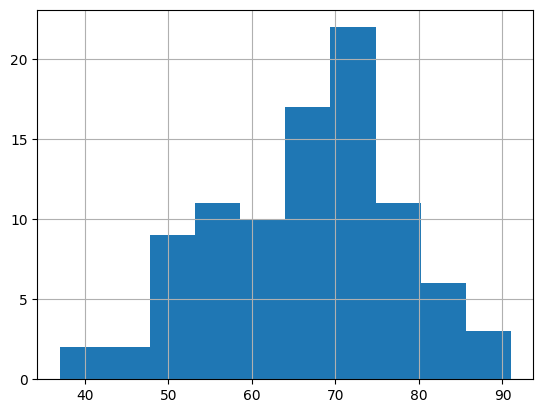

In [17]:
df.groupby('full_name')['age'].max().hist()

In [18]:
# todo: start_date & end_date -> How do we want to handle?

<Axes: >

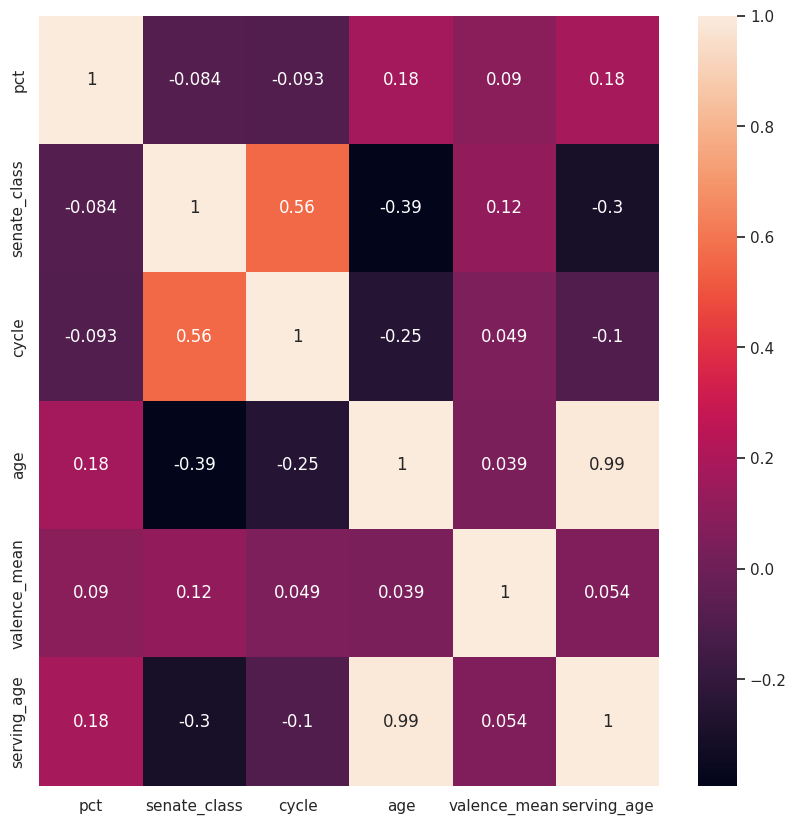

In [19]:
# create heatmap to view correlations
sns.set(font_scale = 1)
plt.figure(figsize = (10,10))
sns.heatmap(df.corr(), annot=True)

### TODO: Senator Photo Enrichment
3 - 20 Photos of senators at various events and points in time

In [20]:
# TODO: Analysis on number and types of images available

### TODO: Emotion Detection
Classification and Valence scores

In [21]:
# todo: update with real inferences

In [22]:
# generating random valence values as a placeholder
#emotions = ['engagement','happiness','anticipation','excitement','confidence','pleasure','peace','disconnection','affection','esteem','sympathy']
#df['top_emotion'] = np.random.choice(emotions, size=len(df))

#df['valence'] = np.random.randint(0,10, size=len(df))

In [23]:
df['valence_mean'].describe()

count    3035.000000
mean       26.044160
std        38.443499
min       -73.293255
25%         5.415104
50%        27.554999
75%        56.318169
max        99.428934
Name: valence_mean, dtype: float64

In [24]:
df['race_majority'].value_counts()

white              2695
black               218
latino hispanic     111
asian                11
Name: race_majority, dtype: int64

In [25]:
df['emotion_majority'].value_counts()

happy       2117
neutral      329
sad          329
angry        159
fear          90
surprise      11
Name: emotion_majority, dtype: int64

In [26]:
# TODO: General EDA on the distribution of emotion inferences like frequency of emotion class and averge valence

### Final Feature Selection

In [27]:
target = ['pct'] # could we do binary classification with positive or negative score?
date_features = ['start_date','end_date','birthday'] # is cycle really "date" or categorical?
categorical_features = ['emotion_majority','race_majority','gender','party','senate_class','stage','cycle']
numerical_features = ['serving_age','valence_mean'] # omitting serving_age due to correlation with age

### Train/Test Split

In [28]:
df.head()

,full_name,pct,birthday,gender,party,senate_class,stage,cycle,start_date,end_date,age,emotion_majority,race_majority,valence_mean,serving_age
0,amy klobuchar,54.0,1960-05-25,F,Democrat,1.0,general,2018,2018-10-15,2018-10-30,64,happy,white,26.80534,58
1,amy klobuchar,55.0,1960-05-25,F,Democrat,1.0,general,2018,2018-11-02,2018-11-04,64,happy,white,26.80534,58
2,amy klobuchar,53.0,1960-05-25,F,Democrat,1.0,general,2018,2018-11-01,2018-11-03,64,happy,white,26.80534,58
3,amy klobuchar,57.0,1960-05-25,F,Democrat,1.0,general,2018,2018-10-29,2018-10-31,64,happy,white,26.80534,58
4,amy klobuchar,56.0,1960-05-25,F,Democrat,1.0,general,2018,2018-10-15,2018-10-17,64,happy,white,26.80534,58


In [29]:
df.isnull().sum()

full_name           0
pct                 0
birthday            0
gender              0
party               0
senate_class        0
stage               0
cycle               0
start_date          0
end_date            0
age                 0
emotion_majority    0
race_majority       0
valence_mean        0
serving_age         0
dtype: int64

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3035 entries, 0 to 3034
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   full_name         3035 non-null   object        
 1   pct               3035 non-null   float64       
 2   birthday          3035 non-null   datetime64[ns]
 3   gender            3035 non-null   object        
 4   party             3035 non-null   object        
 5   senate_class      3035 non-null   float64       
 6   stage             3035 non-null   object        
 7   cycle             3035 non-null   int64         
 8   start_date        3035 non-null   datetime64[ns]
 9   end_date          3035 non-null   datetime64[ns]
 10  age               3035 non-null   int64         
 11  emotion_majority  3035 non-null   object        
 12  race_majority     3035 non-null   object        
 13  valence_mean      3035 non-null   float64       
 14  serving_age       3035 n

In [31]:
df[categorical_features] = df[categorical_features].astype(str)

In [32]:
#using random shuffle
X_train, X_test, y_train, y_test = train_test_split(df[categorical_features + numerical_features],df[target], test_size=0.2, random_state=42)

In [33]:
X_train

,emotion_majority,race_majority,gender,party,senate_class,stage,cycle,serving_age,valence_mean
1097,sad,white,M,Democrat,2.0,general,2020,33,8.028879
407,sad,white,M,Republican,1.0,general,2018,58,-29.753430
2716,happy,white,M,Democrat,1.0,general,2024,70,98.737377
999,neutral,white,M,Democrat,2.0,general,2020,68,-2.723335
1222,happy,white,F,Republican,3.0,runoff,2020,49,-3.193533
...,...,...,...,...,...,...,...,...,...
1638,neutral,white,M,Democrat,3.0,general,2020,56,45.874163
1095,sad,white,M,Democrat,2.0,general,2020,33,8.028879
1130,happy,white,M,Democrat,1.0,general,2024,67,63.739560
1294,happy,white,F,Republican,3.0,runoff,2020,49,-3.193533


### Normalize Numeric Features

In [34]:
# separate pipeline for numeric so more flexible with real data
num_pipe = Pipeline([
  ('std_scaler', StandardScaler())
])

### Feat Pipeline

In [35]:
ctprocessor = ColumnTransformer(
  transformers=[
  ('numerical', StandardScaler(),numerical_features ),
  ('cat', OneHotEncoder(handle_unknown="ignore", drop='if_binary'),categorical_features),
  ],
  remainder='passthrough'
)

In [36]:
#display
set_config(display='diagram')
display(ctprocessor)

ColumnTransformer(remainder='passthrough',
                  transformers=[('numerical', StandardScaler(),
                                 ['serving_age', 'valence_mean']),
                                ('cat',
                                 OneHotEncoder(drop='if_binary',
                                               handle_unknown='ignore'),
                                 ['emotion_majority', 'race_majority', 'gender',
                                  'party', 'senate_class', 'stage', 'cycle'])])

## Modeling

### Helper functions

In [37]:
## helper function for ensembling models
# evaluate a give model using cross-validation
def evaluate_model(model, X_train, y_train):
    cv = KFold(n_splits=4)
    pipeline = Pipeline(steps=[('preprocessor', ctprocessor), ('model',model)])

    avg_mse_score = -1*np.mean(cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='neg_mean_squared_error'))
    avg_mae_score = -1*np.mean(cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='neg_mean_absolute_error'))
    avg_r2_score = np.mean(cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='r2'))

    return {'mse':avg_mse_score,'mae':avg_mae_score,'r2':avg_r2_score}

### Supervised Modeling - Traditional Methods

In [38]:
ctprocessor.set_output(transform='default')

ColumnTransformer(remainder='passthrough',
                  transformers=[('numerical', StandardScaler(),
                                 ['serving_age', 'valence_mean']),
                                ('cat',
                                 OneHotEncoder(drop='if_binary',
                                               handle_unknown='ignore'),
                                 ['emotion_majority', 'race_majority', 'gender',
                                  'party', 'senate_class', 'stage', 'cycle'])])

#### Linear Regression
Numeric features are standardized using StandardScaler and Categorical features One Hot Encoding

In [39]:
lr = LinearRegression()

In [40]:
lr_pipeline = Pipeline(steps=[('preprocessor', ctprocessor), ('model',lr)])
lr_pipeline.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numerical', StandardScaler(),
                                                  ['serving_age',
                                                   'valence_mean']),
                                                 ('cat',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore'),
                                                  ['emotion_majority',
                                                   'race_majority', 'gender',
                                                   'party', 'senate_class',
                                                   'stage', 'cycle'])])),
                ('model', LinearRegression())])

##### Training Scores
Refer to this for evaluation of train/test scores: https://datascience.stackexchange.com/questions/70054/interpretation-for-test-score-training-score-and-validation-score-in-machine-l

In [41]:
lr_train_scores = evaluate_model(lr,X_train,y_train)
lr_train_scores

{'mse': 30.824642387397677,
 'mae': 4.048786295304778,
 'r2': 0.46587250932784896}

##### Testing Scores

In [42]:
lr_scores = evaluate_model(lr,X_test,y_test)
lr_scores

{'mse': 28.233174344218074,
 'mae': 3.919715361004026,
 'r2': 0.45108282797874055}

#### Decision Tree

NOTE: SKLearn's Decision Tree Algorithm DOES NOT allow direct use of cateogrical features. Not clear if there is a Python package that supports this. LabelEncoding only works if there is a nominal relationship in the features.

AKA don't need encoded categorical features

In [43]:
dtr = DecisionTreeRegressor(random_state=0)

In [44]:
dtr_pipeline = Pipeline(steps=[('preprocessor', ctprocessor), ('model',dtr)])
dtr_pipeline.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numerical', StandardScaler(),
                                                  ['serving_age',
                                                   'valence_mean']),
                                                 ('cat',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore'),
                                                  ['emotion_majority',
                                                   'race_majority', 'gender',
                                                   'party', 'senate_class',
                                                   'stage', 'cycle'])])),
                ('model', DecisionTreeRegressor(random_state=0))])

##### Training Scores
Refer to this for evaluation of train/test scores: https://datascience.stackexchange.com/questions/70054/interpretation-for-test-score-training-score-and-validation-score-in-machine-l

In [45]:
dtr_train_scores = evaluate_model(dtr,X_train,y_train)
dtr_train_scores

{'mse': 19.391474691018402, 'mae': 3.113904657235451, 'r2': 0.6643302622504921}

##### Testing Scores

In [46]:
dtr_scores = evaluate_model(dtr,X_test,y_test)
dtr_scores

{'mse': 20.380787151594355,
 'mae': 3.2479968613131134,
 'r2': 0.6043028323623014}

Feature importance based on mean decrease in impurity

https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

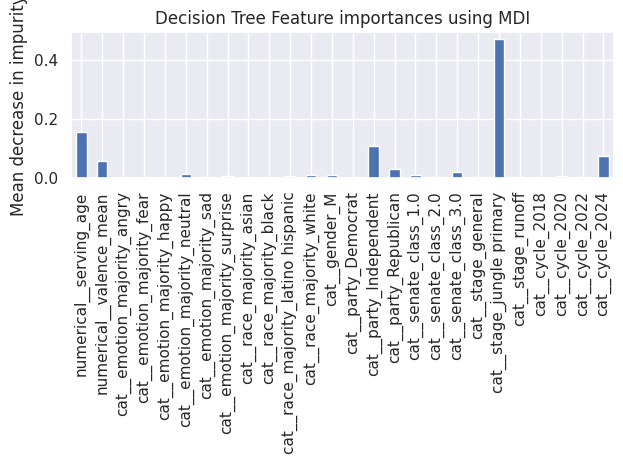

In [47]:
feature_names = dtr_pipeline[:-1].get_feature_names_out()
forest_importances = pd.Series(dtr.feature_importances_, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Decision Tree Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

#### Other Methods
K Nearest Neighbors Regressor

Requires Encoding

In [48]:
knr = KNeighborsRegressor(n_neighbors=2)

In [49]:
knr_pipeline = Pipeline(steps=[('preprocessor', ctprocessor), ('model',knr)])
knr_pipeline.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numerical', StandardScaler(),
                                                  ['serving_age',
                                                   'valence_mean']),
                                                 ('cat',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore'),
                                                  ['emotion_majority',
                                                   'race_majority', 'gender',
                                                   'party', 'senate_class',
                                                   'stage', 'cycle'])])),
                ('model', KNeighborsRegressor(n_neighbors=2))])

##### Training Scores
Refer to this for evaluation of train/test scores: https://datascience.stackexchange.com/questions/70054/interpretation-for-test-score-training-score-and-validation-score-in-machine-l

In [50]:
knr_train_scores = evaluate_model(knr,X_train,y_train)
knr_train_scores

{'mse': 23.902832918039543,
 'mae': 3.5298331960461287,
 'r2': 0.5841982295192742}

##### Testing Scores

In [51]:
knr_scores = evaluate_model(knr,X_test,y_test)
knr_scores

{'mse': 26.199769954415736,
 'mae': 3.8717903123910773,
 'r2': 0.4913199143751178}

### Supervised Methods - Ensemble Learning

#### Random Forest

In [52]:
rf = RandomForestRegressor(random_state=42)

In [53]:
rf_pipeline = Pipeline(steps=[('preprocessor', ctprocessor), ('model', rf)])
rf_pipeline.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numerical', StandardScaler(),
                                                  ['serving_age',
                                                   'valence_mean']),
                                                 ('cat',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore'),
                                                  ['emotion_majority',
                                                   'race_majority', 'gender',
                                                   'party', 'senate_class',
                                                   'stage', 'cycle'])])),
                ('model', RandomForestRegressor(random_state=42))])

##### Training Scores
Refer to this for evaluation of train/test scores: https://datascience.stackexchange.com/questions/70054/interpretation-for-test-score-training-score-and-validation-score-in-machine-l

In [54]:
rf_train_scores = evaluate_model(rf,X_train,y_train)
rf_train_scores

{'mse': 18.538885506670972,
 'mae': 3.0793934727701746,
 'r2': 0.6780026481573591}

##### Testing Scores

In [55]:
rf_scores = evaluate_model(rf,X_test,y_test)
rf_scores

{'mse': 19.54509519315457, 'mae': 3.208824615204209, 'r2': 0.6201892400732449}

Feature importance based on mean decrease in impurity

https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

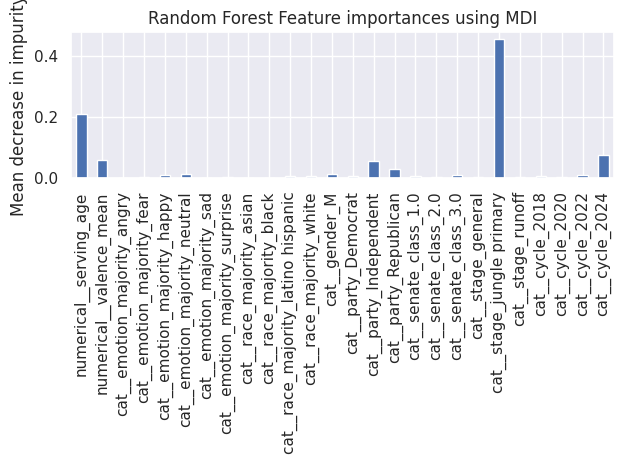

In [56]:
feature_names = rf_pipeline[:-1].get_feature_names_out()
forest_importances = pd.Series(rf.feature_importances_, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Random Forest Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

#### CatBoost
No Feature Processing Needed

https://catboost.ai/en/docs/features/categorical-features

In [57]:
! pip install catboost

In [58]:
from catboost import CatBoostRegressor, Pool

In [59]:
# https://towardsdatascience.com/how-do-you-use-categorical-features-directly-with-catboost-947b211c2923
cbr = CatBoostRegressor(n_estimators=200,loss_function='RMSE',learning_rate=0.4,depth=3, task_type='CPU',random_state=1,verbose=False)

In [60]:
pool_train = Pool(X_train, y_train, cat_features = categorical_features)
pool_test = Pool(X_test, cat_features = categorical_features)

In [61]:
cbr.fit(pool_train)

##### Training Scores
Refer to this for evaluation of train/test scores: https://datascience.stackexchange.com/questions/70054/interpretation-for-test-score-training-score-and-validation-score-in-machine-l

In [62]:
train_predictions = cbr.predict(pool_train)

In [63]:
cbr_train_mse = mean_squared_error(y_train, train_predictions)
cbr_train_mae = mean_absolute_error(y_train, train_predictions)
cbr_train_r2 = r2_score(y_train, train_predictions)

In [64]:
cbr_train_scores = {'mse':cbr_train_mse,'mae':cbr_train_mae,'r2':cbr_train_r2}
cbr_train_scores

{'mse': 16.440374830473036,
 'mae': 2.9924856065807304,
 'r2': 0.7164305308589372}

##### Testing Scores

In [65]:
test_predictions = cbr.predict(pool_test)

In [66]:
cbr_mse = mean_squared_error(y_test, test_predictions)
cbr_mae = mean_absolute_error(y_test, test_predictions)
cbr_r2 = r2_score(y_test, test_predictions)

In [67]:
cbr_scores = {'mse':cbr_mse,'mae':cbr_mae,'r2':cbr_r2}
cbr_scores

{'mse': 16.894835890499888, 'mae': 2.992591728473356, 'r2': 0.674976997274682}

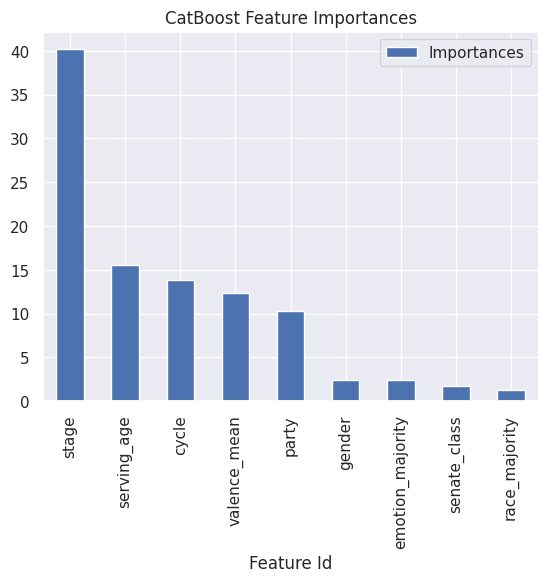

In [68]:
cbr.get_feature_importance(prettified=True).plot.bar(x='Feature Id', y='Importances')
plt.xticks(rotation=90)
plt.title("CatBoost Feature Importances")
fig.tight_layout()

#### CatBoost WITH OneHotEncoding and StdScaler Transformed Data

https://catboost.ai/en/docs/features/categorical-features

In [69]:
ctprocessor.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('numerical', StandardScaler(),
                                 ['serving_age', 'valence_mean']),
                                ('cat',
                                 OneHotEncoder(drop='if_binary',
                                               handle_unknown='ignore'),
                                 ['emotion_majority', 'race_majority', 'gender',
                                  'party', 'senate_class', 'stage', 'cycle'])])

In [70]:
X_train_t = ctprocessor.transform(X_train)
X_test_t = ctprocessor.transform(X_test)

In [71]:
features = ctprocessor.get_feature_names_out()
X_train_t = pd.DataFrame(X_train_t, columns=features)
X_test_t = pd.DataFrame(X_test_t, columns=features)

In [72]:
# https://towardsdatascience.com/how-do-you-use-categorical-features-directly-with-catboost-947b211c2923
cbr_t = CatBoostRegressor(n_estimators=200,loss_function='RMSE',learning_rate=0.4,depth=3, task_type='CPU',random_state=1,verbose=False)

In [73]:
pool_train_t = Pool(X_train_t, y_train)
pool_test_t = Pool(X_test_t)

In [74]:
cbr_t.fit(pool_train_t)

##### Training Scores
Refer to this for evaluation of train/test scores: https://datascience.stackexchange.com/questions/70054/interpretation-for-test-score-training-score-and-validation-score-in-machine-l

In [75]:
train_predictions_t = cbr_t.predict(pool_train_t)

In [76]:
cbr_train_mse_t = mean_squared_error(y_train, train_predictions_t)
cbr_train_mae_t = mean_absolute_error(y_train, train_predictions_t)
cbr_train_r2_t = r2_score(y_train, train_predictions_t)

In [77]:
cbr_train_scores_t = {'mse':cbr_train_mse_t,'mae':cbr_train_mae_t,'r2':cbr_train_r2_t}
cbr_train_scores_t

{'mse': 14.876198256769465, 'mae': 2.828867153125786, 'r2': 0.7434100082261965}

##### Testing Scores

In [78]:
test_predictions_t = cbr_t.predict(pool_test_t)

In [79]:
cbr_mse_t = mean_squared_error(y_test, test_predictions_t)
cbr_mae_t = mean_absolute_error(y_test, test_predictions_t)
cbr_r2_t = r2_score(y_test, test_predictions_t)

In [80]:
cbr_scores_t = {'mse':cbr_mse_t,'mae':cbr_mae_t,'r2':cbr_r2_t}
cbr_scores_t

{'mse': 17.122517607183465,
 'mae': 3.0054466497315273,
 'r2': 0.6705968543894965}

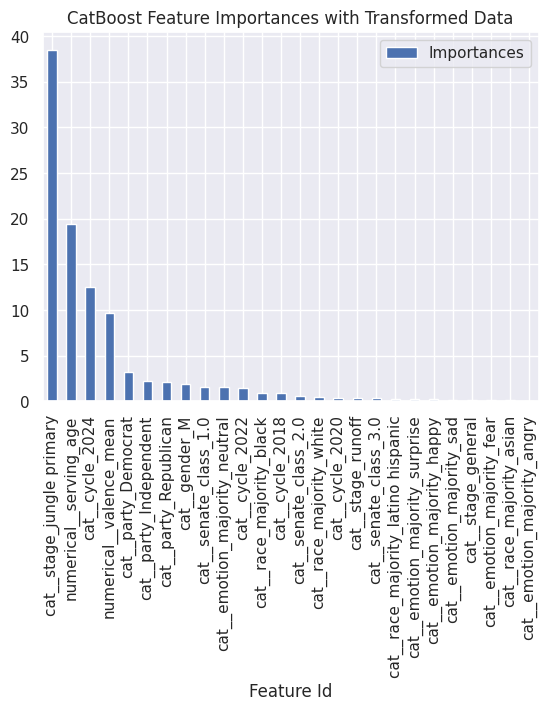

In [81]:
cbr_t.get_feature_importance(prettified=True).plot.bar(x='Feature Id', y='Importances')
plt.xticks(rotation=90)
plt.title("CatBoost Feature Importances with Transformed Data")
fig.tight_layout()

In [82]:
# TODO: Properly Extract Feature Names

#### CatBoost Witholding Emotion Features
No Feature Processing Needed

https://catboost.ai/en/docs/features/categorical-features

In [83]:
# https://towardsdatascience.com/how-do-you-use-categorical-features-directly-with-catboost-947b211c2923
cbr_ne = CatBoostRegressor(n_estimators=200,loss_function='RMSE',learning_rate=0.4,depth=3, task_type='CPU',random_state=1,verbose=False)

In [84]:
categorical_features_ne = ['gender', 'party', 'senate_class', 'stage', 'cycle', 'race_majority']

In [85]:
pool_train_ne = Pool(X_train.drop(columns=['emotion_majority','valence_mean']), y_train, cat_features = categorical_features_ne)
pool_test_ne = Pool(X_test.drop(columns=['emotion_majority','valence_mean']), cat_features = categorical_features_ne)

In [86]:
cbr_ne.fit(pool_train_ne)

##### Training Scores
Refer to this for evaluation of train/test scores: https://datascience.stackexchange.com/questions/70054/interpretation-for-test-score-training-score-and-validation-score-in-machine-l

In [87]:
train_predictions_ne = cbr_ne.predict(pool_train_ne)

In [88]:
cbr_train_mse_ne = mean_squared_error(y_train, train_predictions_ne)
cbr_train_mae_ne = mean_absolute_error(y_train, train_predictions_ne)
cbr_train_r2_ne = r2_score(y_train, train_predictions_ne)

In [89]:
cbr_train_scores_ne = {'mse':cbr_train_mse_ne,'mae':cbr_train_mae_ne,'r2':cbr_train_r2_ne}
cbr_train_scores_ne

{'mse': 18.759931719396654,
 'mae': 3.2107907931881097,
 'r2': 0.6764219834616245}

##### Testing Scores

In [90]:
test_predictions_ne = cbr_ne.predict(pool_test_ne)

In [91]:
cbr_mse_ne = mean_squared_error(y_test, test_predictions_ne)
cbr_mae_ne = mean_absolute_error(y_test, test_predictions_ne)
cbr_r2_ne = r2_score(y_test, test_predictions_ne)

In [92]:
cbr_scores_ne = {'mse':cbr_mse_ne,'mae':cbr_mae_ne,'r2':cbr_r2_ne}
cbr_scores_ne

{'mse': 17.779589875852157, 'mae': 3.102275781013338, 'r2': 0.657956092256357}

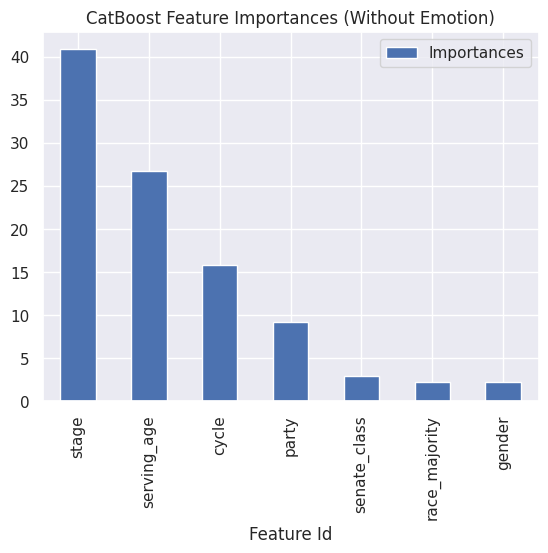

In [93]:
cbr_ne.get_feature_importance(prettified=True).plot.bar(x='Feature Id', y='Importances')
plt.xticks(rotation=90)
plt.title("CatBoost Feature Importances (Without Emotion)")
fig.tight_layout()

## Modeling Evaulation

In [94]:
# TODO: Jungle Primary feature importance potentially very interesting - https://politicaldictionary.com/words/jungle-primary/

## Unsupervised Modeling - TODO Week 10!

### KMeans and Hierarchical Clustering

In [95]:
X = np.array([[1, 2], [1, 4], [1, 0], [10, 2], [10, 4], [10, 0]])
kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto").fit(X)
kmeans.labels_
kmeans.predict([[0, 0], [12, 3]])
kmeans.cluster_centers_

array([[10.,  2.],
       [ 1.,  2.]])

In [96]:
X = np.array([[1, 2], [1, 4], [1, 0], [4, 2], [4, 4], [4, 0]])
clustering = AgglomerativeClustering().fit(X)
clustering.labels_

array([1, 1, 1, 0, 0, 0])